<a href="https://colab.research.google.com/github/matheusrbg/Reconhecimento-do-Alfabeto-em-Libras/blob/main/Avalia%C3%A7%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Inicio

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
from tqdm.notebook import tqdm
import time
import os
import copy
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
use_gpu = torch.cuda.is_available()
DIR = "drive/MyDrive/LIBRAS/" 

classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'I', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'Y']
NUM_CLASSES = len(classes)

def load_vgg(num_classes, model_path):    
    model = torchvision.models.vgg19_bn(weights='IMAGENET1K_V1')

    # Newly created modules have require_grad=True by default
    num_features = model.classifier[6].in_features
    features = list(model.classifier.children())[:-1] # Remove last layer
    features.extend([nn.Linear(num_features, num_classes)]) # Add our layer with 4 outputs
    model.classifier = nn.Sequential(*features) # Replace the model classifier

    # Load fine tuned model
    model.load_state_dict(torch.load(model_path))
    
    if use_gpu:
        model.to(device)
        
    return model
    
def load_resnet(num_classes, model_path):
    model = torchvision.models.resnet34(weights='IMAGENET1K_V1')

    model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
    torch.nn.init.xavier_uniform_(model.fc.weight)

    # Load fine tuned model
    model.load_state_dict(torch.load(model_path))
    
    if use_gpu:
        model.to(device)

    return model

def load_googlenet(num_classes, model_path):
   
    model = torchvision.models.googlenet(weights='IMAGENET1K_V1')
    
    if model_path == DIR + "googlenet_libras.pt" or model_path == DIR + "googlenet2_libras.pt":
       
        model.fc=nn.Sequential(
            nn.Linear(in_features=1024,out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512,out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128,out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32,out_features=num_classes,bias=True)
        )
    else:
        model.fc=nn.Linear(in_features=1024,out_features=num_classes)

    # Load fine tuned model
    model.load_state_dict(torch.load(model_path))
    
    if use_gpu:
        model.to(device)

    return model    

def load_convnext(num_classes, model_path):
  
    model = torchvision.models.convnext_tiny(weights='IMAGENET1K_V1')
  
    n_inputs = None
    for name, child in model.named_children():
        if name == 'classifier':
            for sub_name, sub_child in child.named_children():
                if sub_name == '2':
                    n_inputs = sub_child.in_features

    model.classifier = nn.Sequential(
        nn.LayerNorm((768,1,1), eps=1e-06, elementwise_affine=True),
        nn.Flatten(start_dim=1, end_dim=-1),
        nn.Linear(n_inputs, 2048, bias=True),
        nn.BatchNorm1d(2048),
        nn.ReLU(),
        nn.Dropout(0.1),
        nn.Linear(2048, 2048),
        nn.BatchNorm1d(2048),
        nn.ReLU(),
        nn.Linear(2048, num_classes),
        nn.LogSoftmax(dim=1)

    )

    # Load fine tuned model
    model.load_state_dict(torch.load(model_path))

    if use_gpu:
        model.to(device)

    return model

def chooseModel(model, version):
  if model == 'vgg':
      if version == '1':
          model_path = DIR + "VGG19_libras.pt"
      else:
        model_path = DIR + "VGG19_" + version + "_libras.pt"
      return load_vgg(NUM_CLASSES, model_path)
  elif model == 'resnet':
      if version == '1':
        model_path = DIR + "resnet_libras.pt"
      return load_resnet(NUM_CLASSES, model_path)
  elif model == 'googlenet':
      if version == '1':
          model_path = DIR + "googlenet_libras.pt"
      else:
          model_path = DIR + "googlenet" + version + "_libras.pt"
      return load_googlenet(NUM_CLASSES, model_path)
  elif model == 'convnext':
      if version == '1':
          model_path = DIR + "convnext_libras.pt"      
      else:
          model_path = DIR + "convnext" + version + "_libras.pt"
      return load_convnext(NUM_CLASSES, model_path)

In [ ]:
transform_test = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [ ]:
data_dir = "/content/drive/MyDrive/LIBRAS"
num_workers = 14

image_datasets = {
    'test': datasets.ImageFolder(
        root=os.path.join(data_dir, 'test'), 
        transform=transform_test
    )
}
dataloaders = {
    'test': torch.utils.data.DataLoader(
        image_datasets['test'], batch_size=32,
        shuffle=True, num_workers=num_workers
    )
}
pathloaders = {
    'test': torch.utils.data.DataLoader(
        image_datasets['test'].imgs, batch_size=32,
        shuffle=True, num_workers=num_workers
    ),
}
dataset_sizes = {x: len(image_datasets[x]) for x in ['test']}

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 14 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
def eval_model(model, criterion):
    if use_gpu:
        with torch.no_grad():
            model = model.to(device)

    y_true = []
    y_pred = []
    since = time.time()
    avg_loss = 0
    avg_acc = 0
    loss_test = 0
    acc_test = 0
    
    test_batches = len(dataloaders['test'])
    print("Evaluating model")
    print('-' * 10)
    pbar = tqdm(total=test_batches)
    for i, data in enumerate(dataloaders['test']):
        pbar.update(1)

        model.train(False)
        model.eval()
        
        inputs, labels = data
        
        y_true = y_true + labels.tolist()
        if use_gpu:
            with torch.no_grad():
                inputs, labels = inputs.cuda(), labels.cuda()
        else:
            with torch.no_grad():
                inputs, labels = inputs, labels
        
        outputs = model(inputs)

        _, preds = torch.max(outputs.data, 1)
        loss = criterion(outputs, labels)
        #print(preds)
        y_pred = y_pred + preds.tolist()
        
        loss_test += loss.item()
        acc_test += torch.sum(preds == labels.data)

        del inputs, labels, outputs, preds
        torch.cuda.empty_cache()
        
    avg_loss = loss_test / dataset_sizes['test']
    avg_acc = acc_test / dataset_sizes['test']
    
    elapsed_time = time.time() - since
    print()
    print("Evaluation completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Avg loss (test): {:.4f}".format(avg_loss))
    print("Avg acc (test): {:.4f}".format(avg_acc))
    print('-' * 10)

    return y_pred, y_true

In [ ]:
import itertools

#Plot the confusion matrix. Set Normalize = True/False
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# VGG

Evaluating model
----------


  0%|          | 0/181 [00:00<?, ?it/s]


Evaluation completed in 0m 51s
Avg loss (test): 0.0001
Avg acc (test): 1.0000
----------
Classification Report VGG version:1
              precision    recall  f1-score   support

           A       1.00      1.00      1.00       291
           B       1.00      1.00      1.00       282
           C       1.00      1.00      1.00       293
           D       1.00      1.00      1.00       276
           E       1.00      1.00      1.00       288
           F       1.00      1.00      1.00       226
           G       1.00      1.00      1.00       276
           I       1.00      1.00      1.00       276
           L       1.00      1.00      1.00       270
           M       1.00      1.00      1.00       274
           N       1.00      1.00      1.00       276
           O       1.00      1.00      1.00       276
           P       1.00      1.00      1.00       276
           Q       1.00      1.00      1.00       276
           R       1.00      1.00      1.00       276
         

  0%|          | 0/181 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 14 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(



Evaluation completed in 0m 48s
Avg loss (test): 0.0001
Avg acc (test): 1.0000
----------
Classification Report VGG version:2
              precision    recall  f1-score   support

           A       1.00      1.00      1.00       291
           B       1.00      1.00      1.00       282
           C       1.00      1.00      1.00       293
           D       1.00      1.00      1.00       276
           E       1.00      1.00      1.00       288
           F       1.00      1.00      1.00       226
           G       1.00      1.00      1.00       276
           I       1.00      1.00      1.00       276
           L       1.00      1.00      1.00       270
           M       1.00      1.00      1.00       274
           N       1.00      1.00      1.00       276
           O       1.00      1.00      1.00       276
           P       1.00      1.00      1.00       276
           Q       1.00      1.00      1.00       276
           R       1.00      1.00      1.00       276
         

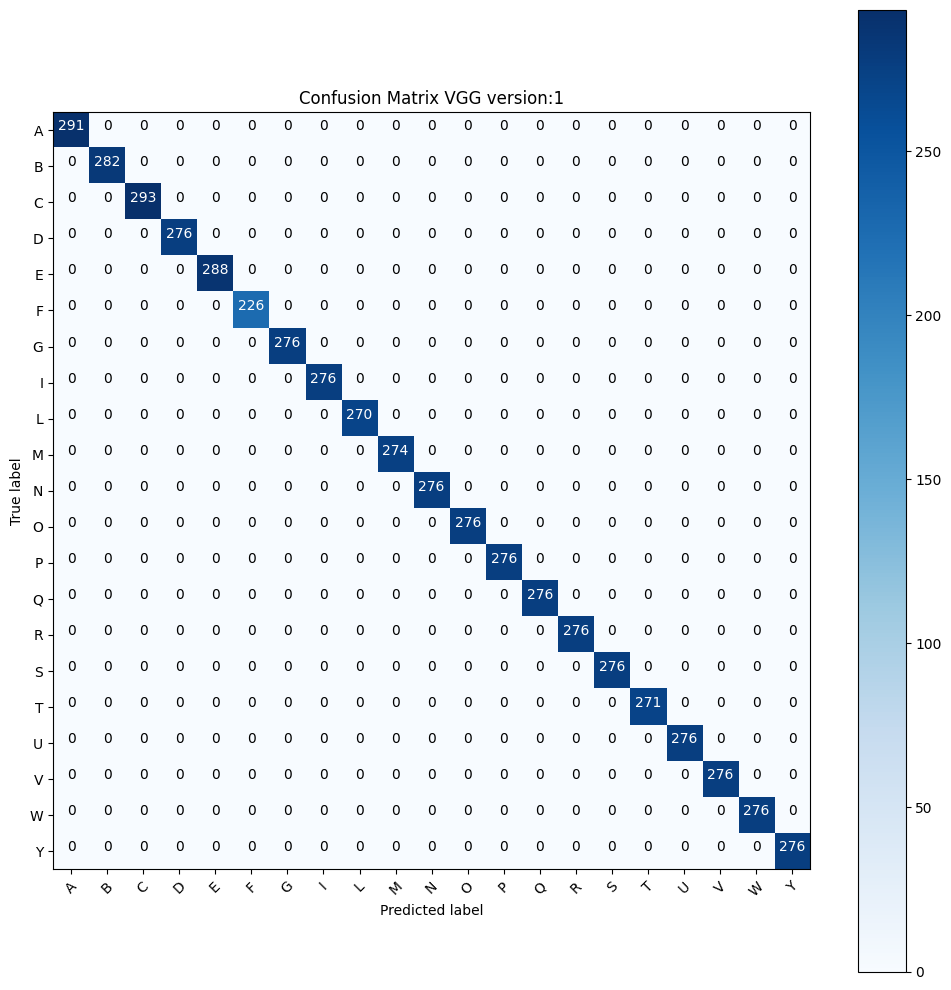

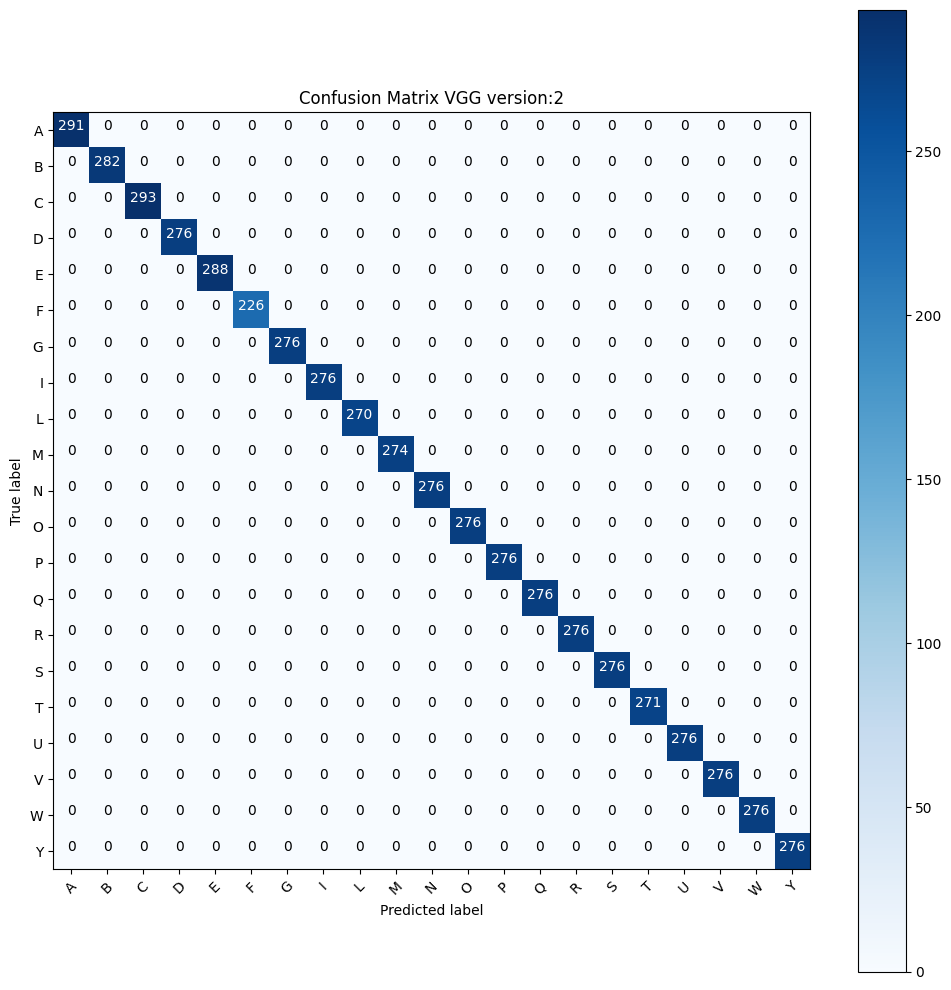

In [ ]:
versions = ['1','2']
for version in versions:
  model = chooseModel("vgg",version)

  criterion = nn.CrossEntropyLoss()
  y_pred, y_true = eval_model(model, criterion)
  pred_class = [classes[i] for i in y_pred]
  acc_class = [classes[i] for i in y_true]

  #Confution Matrix
  cm = confusion_matrix(acc_class, pred_class)
  plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix VGG version:' + version)

  #Classification Report
  print('Classification Report VGG version:'+ version)
  print(classification_report(acc_class, pred_class, target_names=classes))

# GoogLeNet

Evaluating model
----------


  0%|          | 0/91 [00:00<?, ?it/s]


Evaluation completed in 0m 28s
Avg loss (test): 0.0026
Avg acc (test): 0.9473
----------
Classification Report GoogLeNet version:1
              precision    recall  f1-score   support

           A       0.94      1.00      0.97       291
           B       0.91      0.99      0.95       282
           C       0.99      1.00      1.00       293
           D       0.87      0.78      0.82       276
           E       0.94      0.95      0.94       288
           F       0.87      0.79      0.83       226
           G       1.00      0.98      0.99       276
           I       0.85      1.00      0.92       276
           L       1.00      1.00      1.00       270
           M       0.92      0.97      0.94       274
           N       0.95      0.98      0.96       276
           O       0.84      1.00      0.91       276
           P       1.00      0.96      0.98       276
           Q       1.00      0.99      1.00       276
           R       1.00      0.64      0.78       276
   

  0%|          | 0/91 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 14 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(



Evaluation completed in 0m 22s
Avg loss (test): 0.0075
Avg acc (test): 0.8601
----------
Classification Report GoogLeNet version:2
              precision    recall  f1-score   support

           A       0.99      0.90      0.95       291
           B       1.00      0.98      0.99       282
           C       0.89      0.81      0.85       293
           D       0.62      0.75      0.68       276
           E       0.75      0.95      0.84       288
           F       0.78      0.70      0.74       226
           G       0.87      1.00      0.93       276
           I       0.81      0.73      0.77       276
           L       0.67      1.00      0.80       270
           M       0.98      0.98      0.98       274
           N       0.94      0.94      0.94       276
           O       0.90      0.86      0.88       276
           P       0.70      1.00      0.82       276
           Q       0.94      0.98      0.96       276
           R       0.97      0.76      0.85       276
   

  0%|          | 0/91 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 14 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(



Evaluation completed in 0m 23s
Avg loss (test): 0.0105
Avg acc (test): 0.7972
----------
Classification Report GoogLeNet version:3
              precision    recall  f1-score   support

           A       0.99      0.97      0.98       291
           B       0.93      0.97      0.95       282
           C       0.93      0.92      0.93       293
           D       1.00      0.92      0.95       276
           E       1.00      0.92      0.96       288
           F       0.69      1.00      0.82       226
           G       0.99      1.00      0.99       276
           I       1.00      0.68      0.81       276
           L       1.00      0.82      0.90       270
           M       0.31      1.00      0.48       274
           N       0.49      0.71      0.58       276
           O       0.97      0.84      0.90       276
           P       0.67      1.00      0.80       276
           Q       1.00      0.67      0.80       276
           R       0.97      0.26      0.41       276
   

  0%|          | 0/91 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 14 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(



Evaluation completed in 0m 25s
Avg loss (test): 0.0014
Avg acc (test): 0.9806
----------
Classification Report GoogLeNet version:4
              precision    recall  f1-score   support

           A       1.00      0.96      0.98       291
           B       1.00      0.94      0.97       282
           C       1.00      1.00      1.00       293
           D       0.87      1.00      0.93       276
           E       0.90      1.00      0.95       288
           F       0.97      1.00      0.99       226
           G       1.00      1.00      1.00       276
           I       0.96      1.00      0.98       276
           L       0.97      0.99      0.98       270
           M       1.00      0.94      0.97       274
           N       0.95      1.00      0.97       276
           O       1.00      1.00      1.00       276
           P       1.00      1.00      1.00       276
           Q       1.00      1.00      1.00       276
           R       1.00      0.86      0.92       276
   

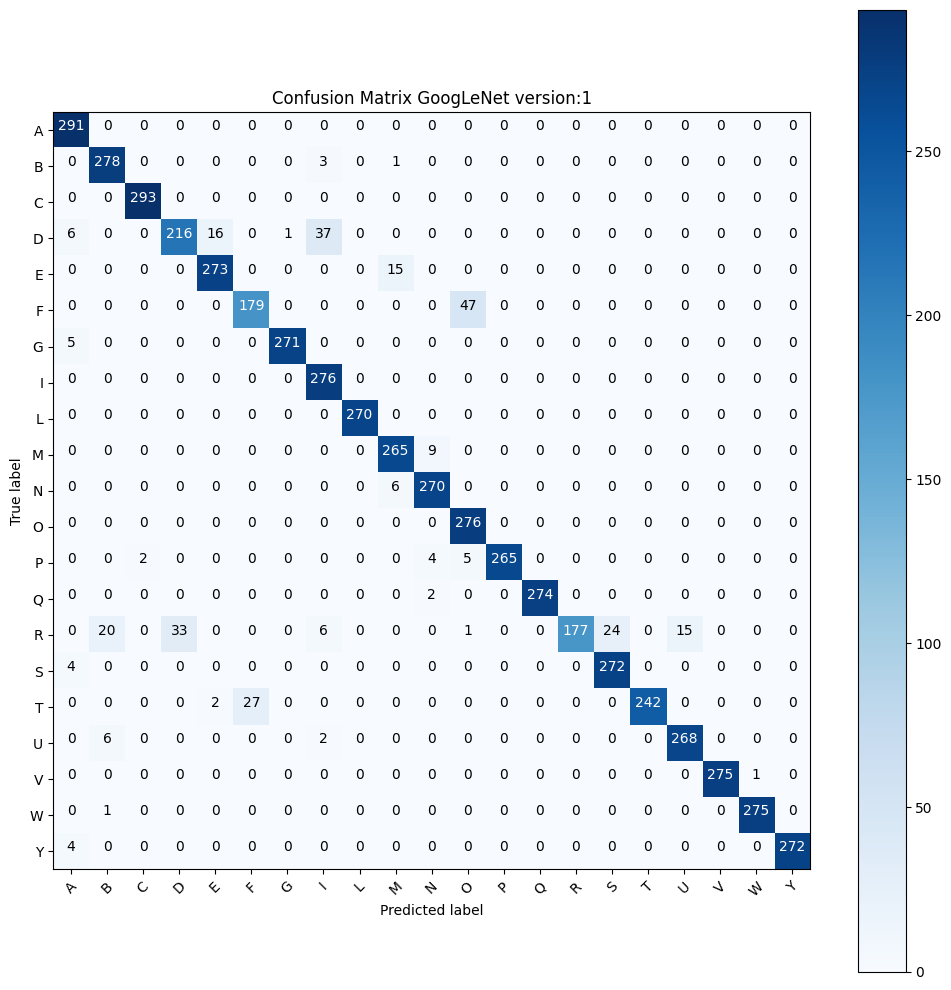

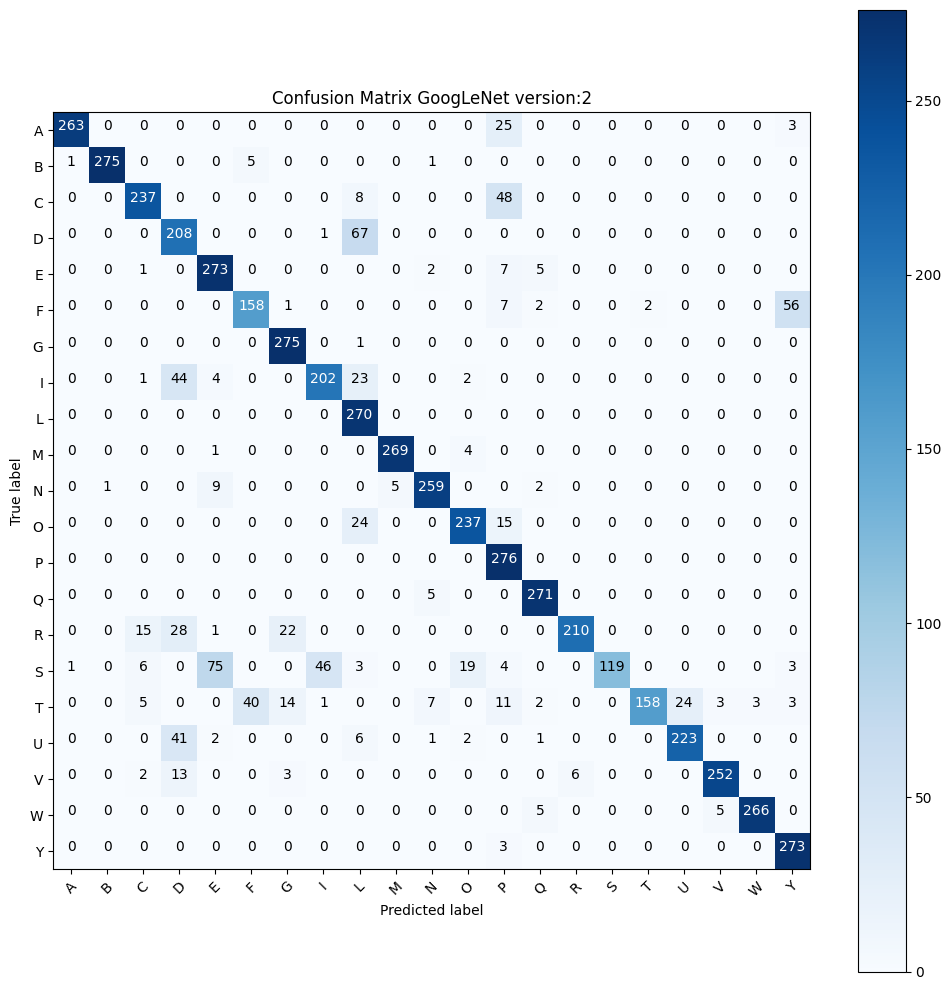

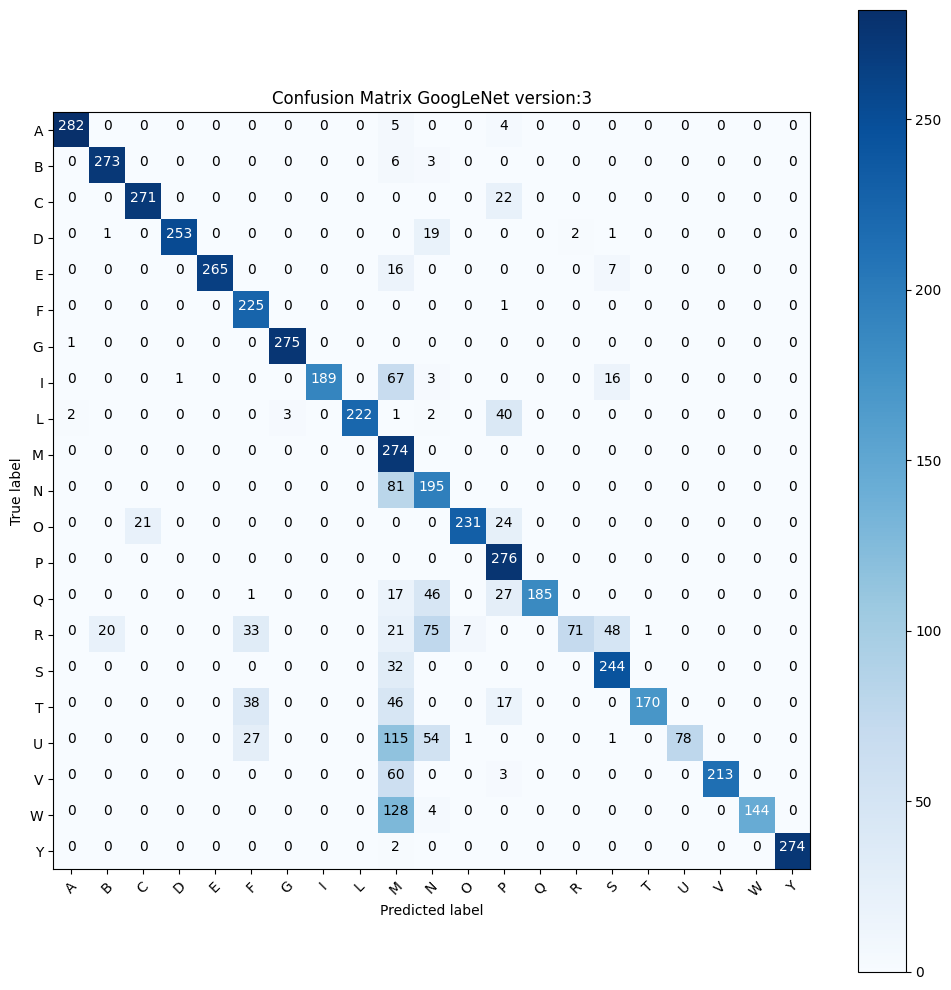

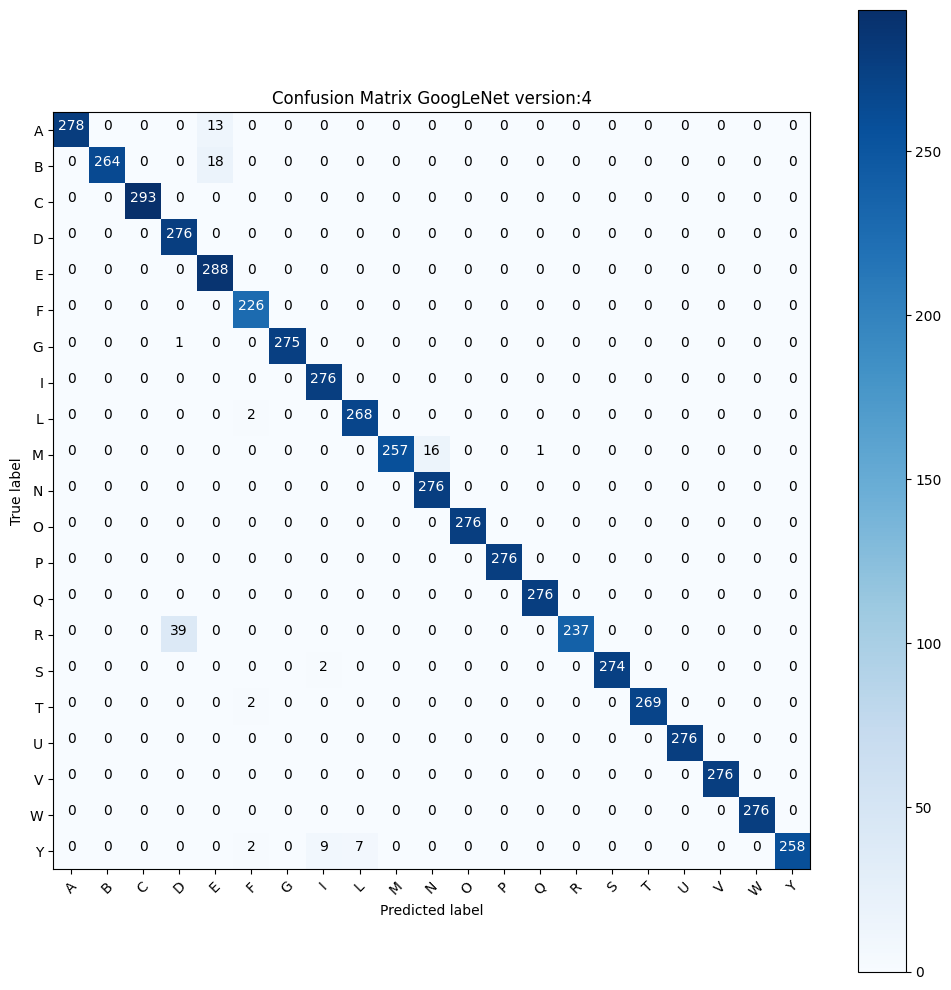

In [ ]:
versions = ['1','2','3','4']
for version in versions:
  model = chooseModel("googlenet",version)

  criterion = nn.CrossEntropyLoss()
  y_pred, y_true = eval_model(model, criterion)
  pred_class = [classes[i] for i in y_pred]
  acc_class = [classes[i] for i in y_true]

  #Confution Matrix
  cm = confusion_matrix(acc_class, pred_class)
  plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix GoogLeNet version:' + version)

  #Classification Report
  print('Classification Report GoogLeNet version:'+ version)
  print(classification_report(acc_class, pred_class, target_names=classes))

# ResNet

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:03<00:00, 26.4MB/s]


Evaluating model
----------


  0%|          | 0/91 [00:00<?, ?it/s]


Evaluation completed in 0m 25s
Avg loss (test): 0.0008
Avg acc (test): 0.9853
----------
Classification Report ResNet version:1
              precision    recall  f1-score   support

           A       1.00      0.97      0.99       291
           B       1.00      1.00      1.00       282
           C       1.00      1.00      1.00       293
           D       1.00      0.96      0.98       276
           E       0.99      1.00      1.00       288
           F       1.00      0.84      0.91       226
           G       0.98      1.00      0.99       276
           I       0.93      1.00      0.97       276
           L       1.00      1.00      1.00       270
           M       1.00      1.00      1.00       274
           N       1.00      1.00      1.00       276
           O       1.00      0.98      0.99       276
           P       1.00      1.00      1.00       276
           Q       1.00      1.00      1.00       276
           R       1.00      1.00      1.00       276
      

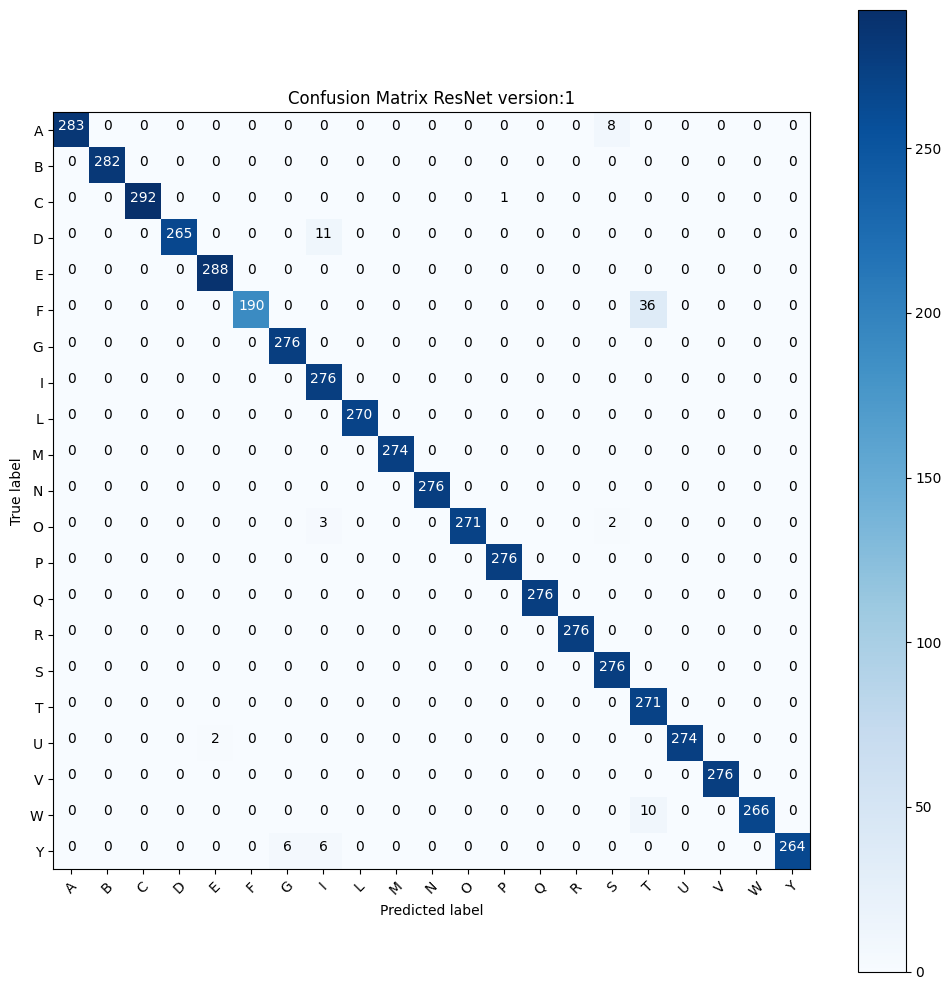

In [ ]:
versions = ['1']
for version in versions:
  model = chooseModel("resnet",version)

  criterion = nn.CrossEntropyLoss()
  y_pred, y_true = eval_model(model, criterion)
  pred_class = [classes[i] for i in y_pred]
  acc_class = [classes[i] for i in y_true]

  #Confution Matrix
  cm = confusion_matrix(acc_class, pred_class)
  plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix ResNet version:' + version)

  #Classification Report
  print('Classification Report ResNet version:'+ version)
  print(classification_report(acc_class, pred_class, target_names=classes))

# ConvNeXt

Evaluating model
----------


  0%|          | 0/91 [00:00<?, ?it/s]


Evaluation completed in 0m 50s
Avg loss (test): 0.0081
Avg acc (test): 0.8452
----------
Classification Report ConvNeXt version:1
              precision    recall  f1-score   support

           A       0.60      0.89      0.72       291
           B       1.00      0.78      0.87       282
           C       1.00      0.97      0.98       293
           D       0.57      0.97      0.72       276
           E       0.99      0.94      0.96       288
           F       0.83      1.00      0.91       226
           G       0.85      0.90      0.88       276
           I       0.73      1.00      0.85       276
           L       1.00      0.98      0.99       270
           M       1.00      0.50      0.67       274
           N       0.97      0.95      0.96       276
           O       0.97      1.00      0.98       276
           P       1.00      1.00      1.00       276
           Q       0.96      0.98      0.97       276
           R       0.47      0.85      0.61       276
    

  0%|          | 0/91 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 14 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(



Evaluation completed in 0m 44s
Avg loss (test): 0.0009
Avg acc (test): 0.9831
----------
Classification Report ConvNeXt version:2
              precision    recall  f1-score   support

           A       0.90      1.00      0.95       291
           B       1.00      1.00      1.00       282
           C       0.95      1.00      0.98       293
           D       0.97      0.97      0.97       276
           E       0.98      0.98      0.98       288
           F       0.98      1.00      0.99       226
           G       1.00      1.00      1.00       276
           I       0.99      0.99      0.99       276
           L       1.00      0.94      0.97       270
           M       0.99      1.00      0.99       274
           N       1.00      0.99      0.99       276
           O       0.99      0.91      0.95       276
           P       1.00      1.00      1.00       276
           Q       1.00      1.00      1.00       276
           R       1.00      1.00      1.00       276
    

  0%|          | 0/91 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 14 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(



Evaluation completed in 0m 44s
Avg loss (test): 0.0000
Avg acc (test): 0.9998
----------
Classification Report ConvNeXt version:3
              precision    recall  f1-score   support

           A       1.00      1.00      1.00       291
           B       1.00      1.00      1.00       282
           C       1.00      1.00      1.00       293
           D       1.00      1.00      1.00       276
           E       1.00      1.00      1.00       288
           F       1.00      1.00      1.00       226
           G       1.00      1.00      1.00       276
           I       1.00      1.00      1.00       276
           L       1.00      1.00      1.00       270
           M       1.00      1.00      1.00       274
           N       1.00      1.00      1.00       276
           O       1.00      1.00      1.00       276
           P       1.00      1.00      1.00       276
           Q       1.00      1.00      1.00       276
           R       1.00      1.00      1.00       276
    

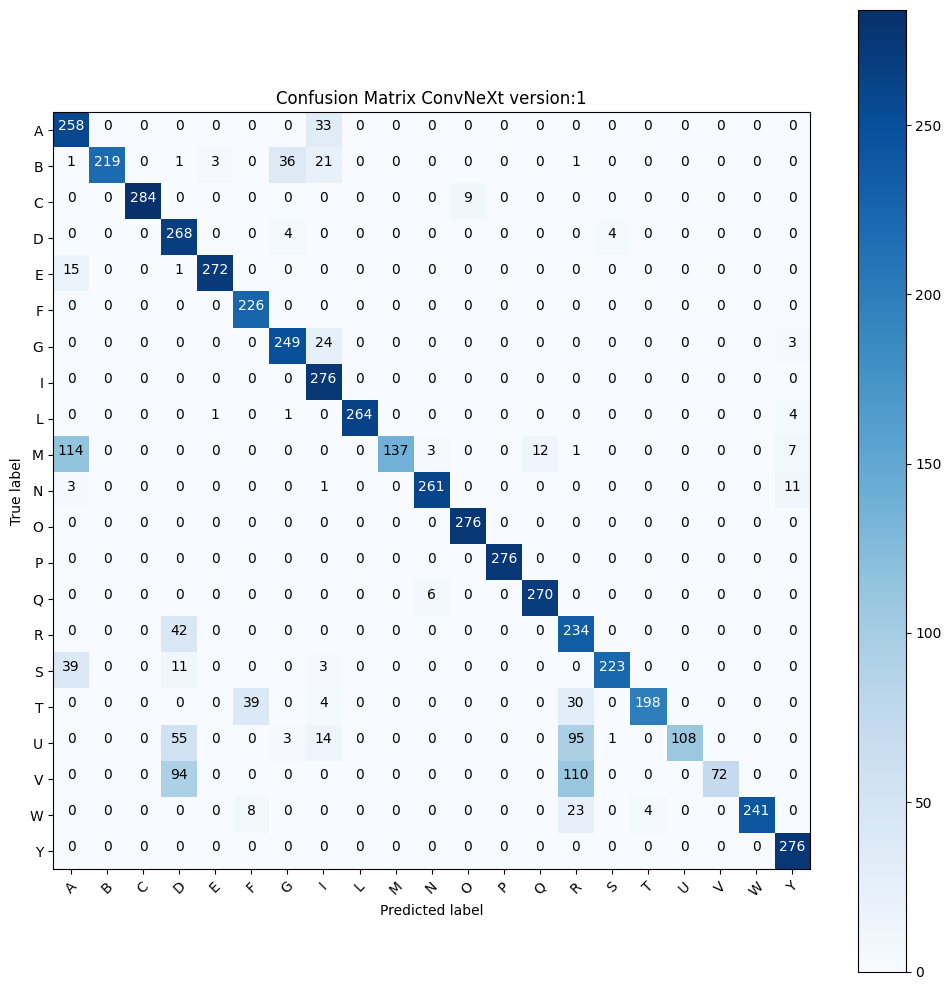

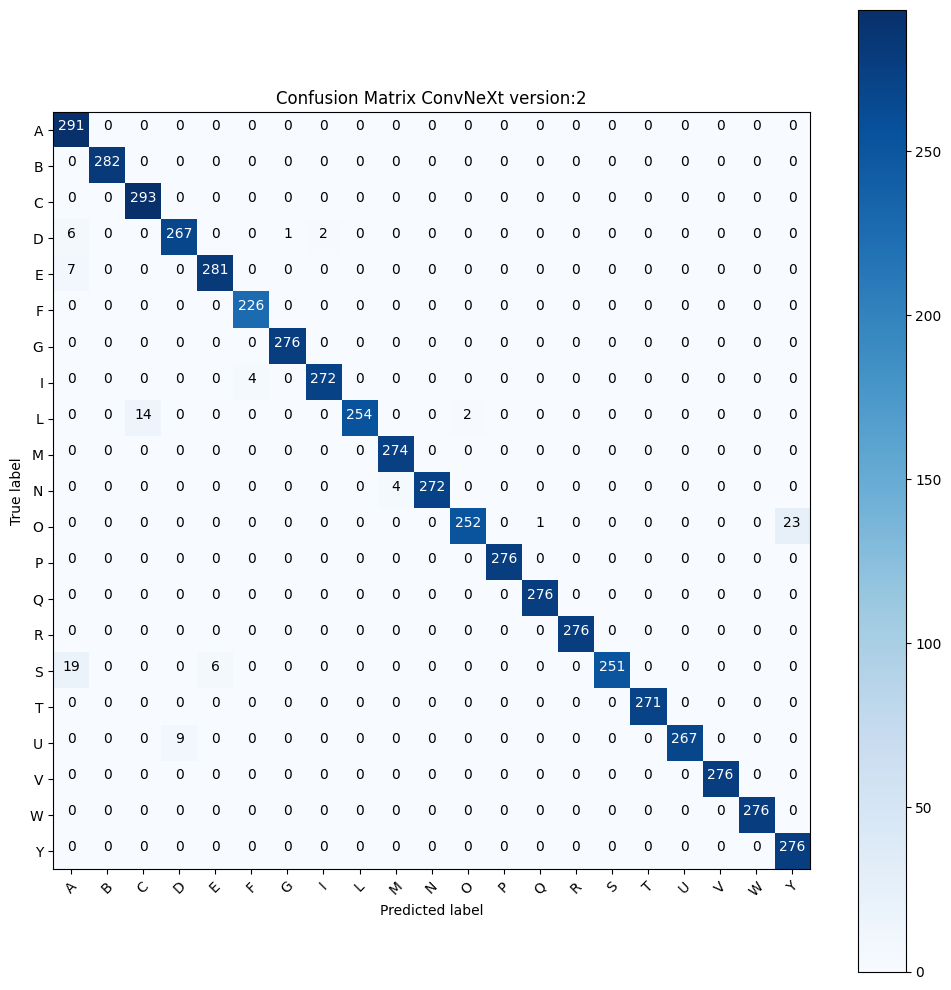

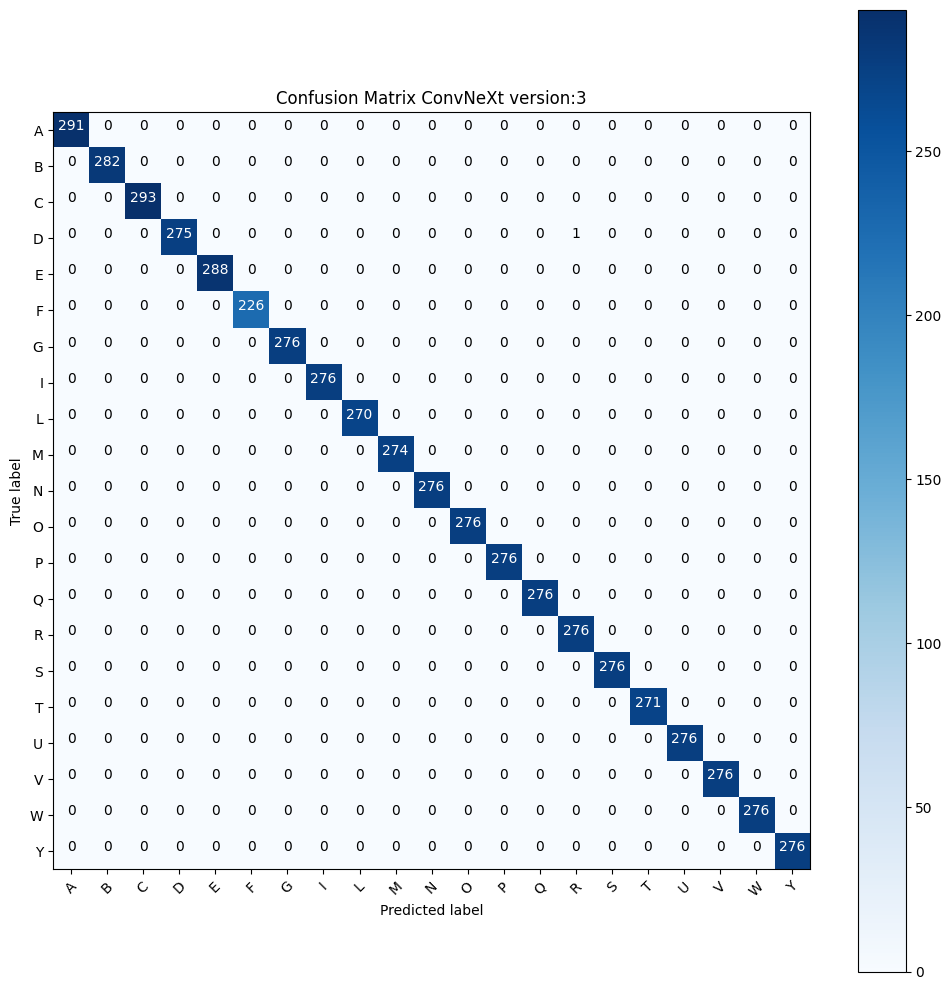

In [ ]:
versions = ['1','2','3']
for version in versions:
  model = chooseModel("convnext",version)

  criterion = nn.CrossEntropyLoss()
  y_pred, y_true = eval_model(model, criterion)
  pred_class = [classes[i] for i in y_pred]
  acc_class = [classes[i] for i in y_true]

  #Confution Matrix
  cm = confusion_matrix(acc_class, pred_class)
  plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix ConvNeXt version:' + version)

  #Classification Report
  print('Classification Report ConvNeXt version:'+ version)
  print(classification_report(acc_class, pred_class, target_names=classes))